In [1]:
import os
from tqdm import tqdm
import random
import datetime
import h5py

import numpy as np
import pandas as pd
import concurrent.futures
import threading
import json

In [2]:

# --- 0. Prerequisite: load main variable ---
MAIN_DIR = "../data/"
ground_height_image = MAIN_DIR + "assets/reprojected_gebco_32630_500m_padded.npy"
index_file = MAIN_DIR + "index.parquet"
save_hf_dataset = "../data/hf_dataset/"

NB_BACK_STEPS = 5
NB_FUTURE_STEPS = 4
NB_PASS_PER_IMAGES = 8
RADAR_NORMALIZATION = 60.0
DEFAULT_VALUE = -1

shape_image = 3472
shape_extrated_image = 256

# we read the index file
index_dataframe = pd.read_parquet(index_file)

# sort by datetime
index_dataframe = index_dataframe.sort_values(by="datetime")

# set datetime as index
index_dataframe = index_dataframe.set_index("datetime")

nb_back_steps = NB_BACK_STEPS
nb_future_steps = NB_FUTURE_STEPS
shape_image = shape_image

# manage ground height image (read the .npy file)
ground_height_image = np.load(ground_height_image)
ground_height_image = (ground_height_image - np.mean(ground_height_image)) / np.std(
    ground_height_image
)

# loop over the index and create the dataset
len_total = len(index_dataframe) - nb_back_steps - nb_future_steps


In [ ]:
def max_pool_2x2(frames):
    """
    Downsamples frames by a factor of 2 using max pooling.
    Assumes input frames have shape (H, W, T) and so you want to reduce to (H/2, W/2, T).
    """
    H, W, T = frames.shape
    # Ensure dimensions are even for 2x2 pooling
    if H % 2 != 0 or W % 2 != 0:
        # Handle odd dimensions if necessary, e.g., by padding or cropping
        # For now, assuming even dimensions based on typical use cases
        raise ValueError("Input frame dimensions must be even for 2x2 max pooling.")

    # Reshape to group 2x2 blocks and apply max pooling
    # (H, W, T) -> (H/2, 2, W/2, 2, T) -> max over axes 1 and 3 -> (H/2, W/2, T)
    pooled_frames = frames.reshape(H // 2, 2, W // 2, 2, T).max(axis=(1, 3))

    return pooled_frames

index = 4001

current_date = index_dataframe.index[index]

dict_return = {}

# now for every image, we select only a random 256x256 patch
x = random.randint(0, shape_image - shape_extrated_image * 2)
y = random.randint(0, shape_image - shape_extrated_image * 2)

array_future_list = []
array_back_list = []

array_back_groundstation_list = []
array_future_groundstation_list = []

array_back_list_time = []

for future in range(nb_future_steps):
    path_file = os.path.join(
        MAIN_DIR, str(index_dataframe["radar_file_path"].iloc[index + future])
    )

    # take
    array = np.array(
        h5py.File(path_file, "r")["dataset1"]["data1"]["data"][
            x : (x + shape_extrated_image * 2) : 2,
            y : (y + shape_extrated_image * 2) : 2,
        ]
    )

    array = array.astype(np.int32)

    array[array == 65535] = -DEFAULT_VALUE

    # if there is nothing > 0, we go on the next item
    if np.sum(array > 0.1) <= 10:
        print("not enaught good point")

    array = np.float32(array) / RADAR_NORMALIZATION  # normalization

    array_future_list.append(array)

    # dict_return["radar_mask_future_" + str(future)] = array != (
    #     -DEFAULT_VALUE / RADAR_NORMALIZATION
    # )

    array_ground_station = np.load(
        os.path.join(
            MAIN_DIR,
            str(index_dataframe["groundstation_file_path"].iloc[index + future]),
        )
    )["image"]

    # maxpool
    array_ground_station = array_ground_station[
        x : (x + shape_extrated_image * 2),
        y : (y + shape_extrated_image * 2),
        :
    ]

    array_ground_station = max_pool_2x2(array_ground_station)

    array_future_groundstation_list.append(array_ground_station)

for back in range(-nb_back_steps, 1):
    path_file = os.path.join(
        MAIN_DIR,
        str(index_dataframe["radar_file_path"].iloc[index + back]),
    )

    # check if the delta with the current time is not too high
    time_back = index_dataframe.index[index + back]
    delta_time = current_date - time_back

    # convert delta time in minutes
    delta_time_minutes = delta_time.total_seconds() / 60

    if delta_time <= datetime.timedelta(hours=2):
        array = np.array(
            h5py.File(path_file, "r")["dataset1"]["data1"]["data"][
                x : (x + shape_extrated_image * 2) : 2,
                y : (y + shape_extrated_image * 2) : 2,
            ]
        )
        array = array.astype(np.int32)
        array[array == 65535] = -DEFAULT_VALUE

    else:
        # print("bad delta time", delta_time)
        array = (
            np.ones((shape_extrated_image, shape_extrated_image), dtype=np.float32)
            * -DEFAULT_VALUE
        )

    array = np.float32(array) / RADAR_NORMALIZATION  # normalization

    # dict_return["radar_back_" + str(back)] = array
    array_back_list.append(array)
    array_back_list_time.append(delta_time_minutes / 60.0)

    ## groundstation setup
    array_ground_station = np.load(
        os.path.join(
            MAIN_DIR,
            str(index_dataframe["groundstation_file_path"].iloc[index + back]),
        )
    )["image"]

    array_ground_station = array_ground_station[
        x : (x + shape_extrated_image * 2),
        y : (y + shape_extrated_image * 2),
        :
    ]

    array_ground_station = max_pool_2x2(array_ground_station)

    array_back_groundstation_list.append(array_ground_station)

dict_return["hour"] = np.int32(current_date.hour)
dict_return["minute"] = np.int32(current_date.minute)

# dd ground height image
dict_return["ground_height_image"] = ground_height_image[
    x : (x + shape_extrated_image * 2) : 2, y : (y + shape_extrated_image * 2) : 2
]

dict_return["radar_future"] = np.stack(array_future_list, axis=0)
dict_return["radar_back"] = np.stack(array_back_list, axis=0)

dict_return["time_radar_back"] = np.array(array_back_list_time, dtype=np.float32)

dict_return["groundstation_future"] = np.stack(
    array_future_groundstation_list, axis=0
)
dict_return["groundstation_back"] = np.stack(array_back_groundstation_list, axis=0)


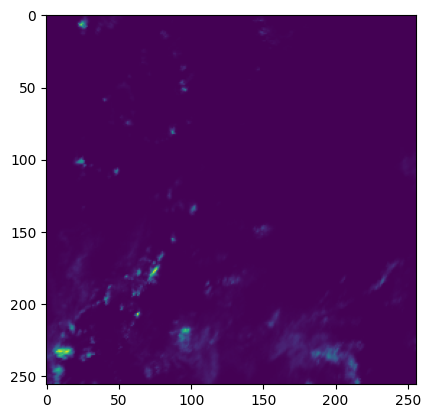

In [21]:
import matplotlib.pyplot as plt

plt.imshow(dict_return["radar_future"][0])
plt.show()

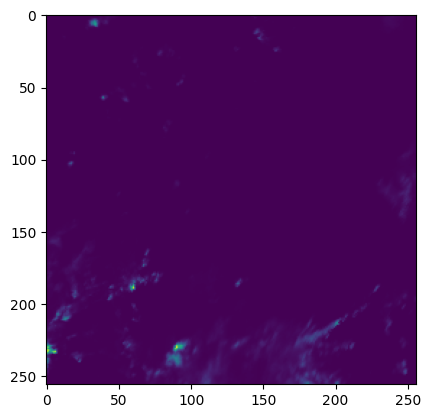

In [22]:
plt.imshow(dict_return["radar_back"][-2])
plt.show()

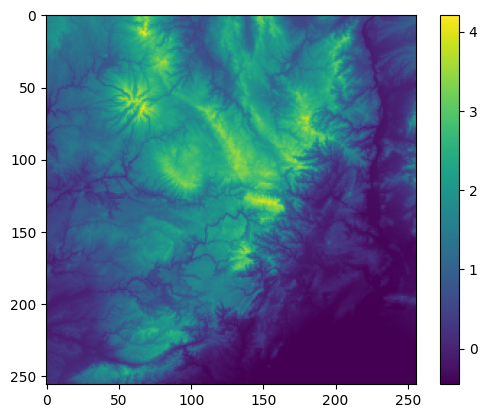

In [23]:
plt.imshow(dict_return["ground_height_image"])
plt.colorbar()
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

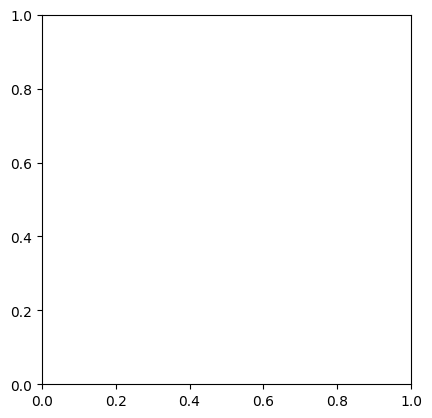

In [24]:
for i in range(len(dict_return["groundstation_future"])):
    plt.figure()
    plt.imshow(dict_return["groundstation_future"][i])
    plt.colorbar()
    plt.show()

In [26]:
dict_return["groundstation_future"]

array([], shape=(4, 0, 187, 4), dtype=float32)

In [38]:
array_ground_station = np.load(
        os.path.join(
            MAIN_DIR,
            str(index_dataframe["groundstation_file_path"].iloc[index + back]),
        )
    )["image"]

In [39]:
array_ground_station.shape

(3472, 3472, 4)

In [40]:
array_ground_station = array_ground_station[
    x : (x + shape_extrated_image * 2),
    y : (y + shape_extrated_image * 2),
    :
]
print(array_ground_station.shape)

(512, 512, 4)


In [41]:
array_ground_station = max_pool_2x2(array_ground_station)
print(array_ground_station.shape)


(256, 256, 4)


In [36]:
print(array_ground_station.shape)

(0, 187, 4)


In [37]:
x

1798